In [5]:
import numpy as np
import gensim
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Embedding, Flatten, merge
from keras.optimizers import Adam
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle

Using Theano backend.


In [6]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))

Number of words in corpora: 26


In [7]:
tmp = list(corpora.items())

In [8]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [9]:
cs=2

In [10]:
c_in_dat = [[text[i+n] for i in range(0, len(text)-1-cs, cs)]
            for n in range(cs)]

In [11]:
xs = [np.stack(c[:-2]) for c in c_in_dat]

In [12]:
c_out_dat = [[text[i+n] for i in range(1, len(text)-cs, cs)]
            for n in range(cs)]

In [13]:
ys = [np.stack(c[:-2]) for c in c_out_dat]

In [14]:
[xs[n][:cs] for n in range(cs)]

[array([2, 4]), array([0, 8])]

In [15]:
[ys[n][:cs] for n in range(cs)]

[array([0, 8]), array([4, 3])]

### Create and train model

In [16]:
n_hidden = 256
n_fac = 4

In [17]:
def embedding_input(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name+'_in')
    emb = Embedding(n_in, n_out, input_length=1, name=name+'_emb')(inp)
    return inp, Flatten()(emb)

In [18]:
c_ins = [embedding_input('c'+str(n), vocab_size, n_fac) for n in range(cs)]

In [19]:
dense_in = Dense(n_hidden, activation='relu')
dense_hidden = Dense(n_hidden, activation='relu', init='identity')
dense_out = Dense(vocab_size, activation='softmax', name='output')

In [20]:
# We're going to pass a vector of all zeros as our starting point - here's our input layers for that:
inp1 = Input(shape=(n_fac,), name='zeros')
hidden = dense_in(inp1)

In [21]:
outs = []

for i in range(cs):
    c_dense = dense_in(c_ins[i][1])
    hidden = dense_hidden(hidden)
    hidden = merge([c_dense, hidden], mode='sum')
    # every layer now has an output
    outs.append(dense_out(hidden))

In [22]:
model = Model([inp1] + [c[0] for c in c_ins], outs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
c0_in (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
c0_emb (Embedding)               (None, 1, 4)          104         c0_in[0][0]                      
____________________________________________________________________________________________________
zeros (InputLayer)               (None, 4)             0                                            
____________________________________________________________________________________________________
c1_in (InputLayer)               (None, 1)             0                                            
___________________________________________________________________________________________

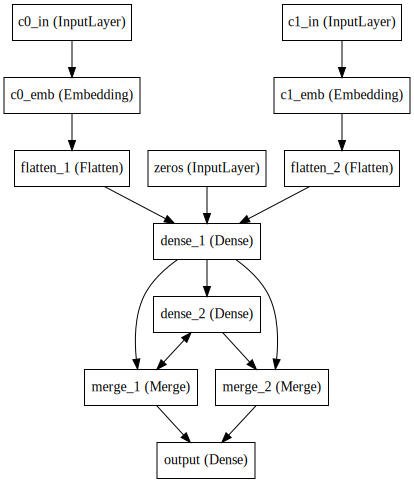

In [24]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [25]:
zeros = np.tile(np.zeros(n_fac), (len(xs[0]),1))
zeros.shape

(12, 4)

In [26]:
model.fit([zeros]+xs, ys, batch_size=1, nb_epoch=100)

Epoch 1/100
12/12 [==============================] - 0s - loss: 6.5480 - output_loss_1: 3.2700 - output_loss_2: 3.2780     
Epoch 2/100
12/12 [==============================] - 0s - loss: 6.4901 - output_loss_1: 3.2624 - output_loss_2: 3.2278     
Epoch 3/100
12/12 [==============================] - 0s - loss: 6.4340 - output_loss_1: 3.2640 - output_loss_2: 3.1699     
Epoch 4/100
12/12 [==============================] - 0s - loss: 6.3390 - output_loss_1: 3.2709 - output_loss_2: 3.0681     
Epoch 5/100
12/12 [==============================] - 0s - loss: 6.1957 - output_loss_1: 3.2998 - output_loss_2: 2.8959     
Epoch 6/100
12/12 [==============================] - 0s - loss: 6.0324 - output_loss_1: 3.3398 - output_loss_2: 2.6925     
Epoch 7/100
12/12 [==============================] - 0s - loss: 5.9585 - output_loss_1: 3.3647 - output_loss_2: 2.5938     
Epoch 8/100
12/12 [==============================] - 0s - loss: 5.8588 - output_loss_1: 3.3417 - output_loss_2: 2.5170     
Epoch 9/

In [30]:
model.save('./models/dev_fast_ai_returning_sequences.h5')

### Test model

In [27]:
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    print(idxs)
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    print(arrs)
    
    p = model.predict(arrs)
    print(p.shape)
    i_max1 = np.argmax(p)
    p[0,i_max1] = 0
    i_max2 = np.argmax(p)
    p[0,i_max2] = 0
    i_max3 = np.argmax(p)

    
    return corpora.id2token[i_max1], corpora.id2token[i_max2], corpora.id2token[i_max3]

In [28]:
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    p = model.predict([np.zeros(n_fac)[np.newaxis,:]] + arrs)
    print(list(inp))
    return [corpora.id2token[np.argmax(o)] for o in p]

In [29]:
get_next(['One', 'two'])

['One', 'two']


['two', 'three']